# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutoria](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (Model, Policy, RealParameter, TimeSeriesOutcome,ScalarOutcome, perform_experiments, ema_logging, SequentialEvaluator, MultiprocessingEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

from lakemodel_function import lake_problem #andere importfuctie toegevoegd

model = Model('LakeModel', function=lake_problem)

model.uncertainties = [RealParameter("mean", 0.01, 0.05),
                       RealParameter("stdev", 0.001, 0.005),
                       RealParameter("b", 0.1, 0.45),
                       RealParameter("q", 2, 4.5),
                       RealParameter("delta", 0.93, 0.99)]

model.levers = [RealParameter((str('l')+str(i)), 0, 0.1) for i in range(100)] # Voor iedere tijdstap een andere value --- Met str(l)
# Q&A example: model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in range(100)]

model.outcomes = [ScalarOutcome('max_P'), #alle vier outcomes uit de py file
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

policies = [Policy("no release", **{l.name:0 for l in model.levers}),
    Policy("max release", **{l.name:0.1 for l in model.levers}),
    Policy("half release", **{l.name:0.05 for l in model.levers}),
    ]

from ema_workbench import (MultiprocessingEvaluator, ema_logging)
ema_logging.log_to_stderr(ema_logging.INFO)
    
with MultiprocessingEvaluator(model) as evaluator: #MultiprocessingEvaluator
    results = evaluator.perform_experiments(scenarios=100, policies=policies, uncertainty_sampling=SOBOL)   
    # I did a 100 given computing power, but do a 1000 if possible
    
experiments, outcomes = results
experiments = experiments.drop([experiments.columns[i] for i in range(5, 105)], axis='columns')
outcomes_interest = outcomes['reliability'] <= np.percentile(outcomes['reliability'],10)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1200 scenarios * 3 policies * 1 model(s) = 3600 experiments
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 1080 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2520 cases completed
[MainProcess/INFO] 2880 cases completed
[MainProcess/INFO] 3240 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


{'S1': array([ 4.25445878e-01, -5.84791877e-04,  2.63350648e-01,  2.64695808e-01,
        7.42775222e-05]), 'S1_conf': array([0.29315429, 0.00102186, 0.17265124, 0.20294037, 0.00060068]), 'ST': array([7.15571948e-01, 1.83200640e-05, 4.45845094e-01, 4.41942478e-01,
       1.27697380e-05]), 'ST_conf': array([2.06529310e-01, 1.82931994e-05, 1.90433860e-01, 1.71172256e-01,
       1.56994552e-05]), 'S2': array([[        nan,  0.12137668,  0.0260928 ,  0.22167865,  0.12084421],
       [        nan,         nan, -0.00179807, -0.00063137, -0.0003449 ],
       [        nan,         nan,         nan,  0.01391842, -0.00844997],
       [        nan,         nan,         nan,         nan, -0.04201639],
       [        nan,         nan,         nan,         nan,         nan]]), 'S2_conf': array([[       nan, 0.40132385, 0.4710765 , 0.4535722 , 0.40171735],
       [       nan,        nan, 0.0024696 , 0.00181567, 0.00159951],
       [       nan,        nan,        nan, 0.29328845, 0.23094578],
       

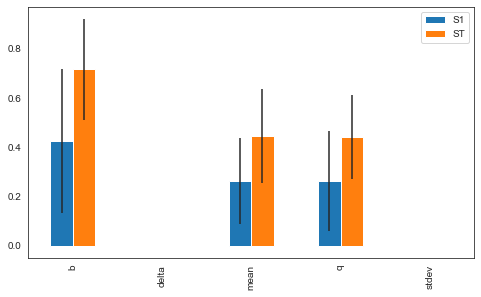

{'S1': array([ 4.24110709e-01,  1.35904307e-04,  1.17019237e-02,  8.16867166e-02,
       -2.14750090e-04]), 'S1_conf': array([3.96145170e-01, 3.60926379e-04, 4.40610283e-02, 8.86181369e-02,
       6.59104069e-04]), 'ST': array([1.02586767e+00, 2.57002105e-06, 1.34232554e-01, 4.82537231e-01,
       3.51765022e-06]), 'ST_conf': array([4.59793741e-01, 3.17027362e-06, 1.46790206e-01, 2.77567855e-01,
       2.57367766e-06]), 'S2': array([[       nan, 0.16136468, 0.25260922, 0.40558945, 0.16182374],
       [       nan,        nan, 0.00072677, 0.00075694, 0.00066758],
       [       nan,        nan,        nan, 0.02409625, 0.04360303],
       [       nan,        nan,        nan,        nan, 0.00617391],
       [       nan,        nan,        nan,        nan,        nan]]), 'S2_conf': array([[       nan, 0.60776846, 0.66192476, 0.74847583, 0.60747442],
       [       nan,        nan, 0.0012527 , 0.00127175, 0.00125123],
       [       nan,        nan,        nan, 0.15907841, 0.16534357],
     

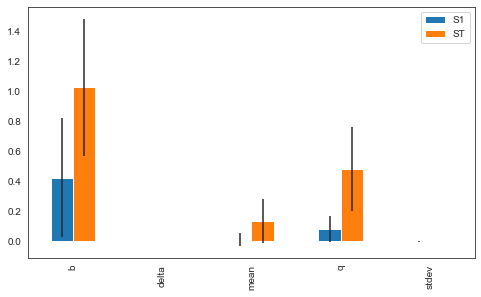

{'S1': array([5.53208381e-01, 1.89649139e-04, 1.17308750e-01, 2.72259664e-01,
       2.96661704e-04]), 'S1_conf': array([0.20401627, 0.00078485, 0.12224181, 0.17927209, 0.00088433]), 'ST': array([7.24460130e-01, 9.05607334e-06, 1.23962703e-01, 4.92570028e-01,
       7.50821610e-06]), 'ST_conf': array([1.98667593e-01, 1.14864404e-05, 6.67296109e-02, 1.32301169e-01,
       7.01904960e-06]), 'S2': array([[        nan, -0.05214199, -0.10210873,  0.06775929, -0.0519125 ],
       [        nan,         nan, -0.00078773, -0.00074242, -0.00066419],
       [        nan,         nan,         nan, -0.10767791, -0.12237591],
       [        nan,         nan,         nan,         nan, -0.0347474 ],
       [        nan,         nan,         nan,         nan,         nan]]), 'S2_conf': array([[       nan, 0.19403207, 0.21197889, 0.2265053 , 0.19417804],
       [       nan,        nan, 0.0013447 , 0.00130059, 0.00134477],
       [       nan,        nan,        nan, 0.13763105, 0.13410732],
       [    

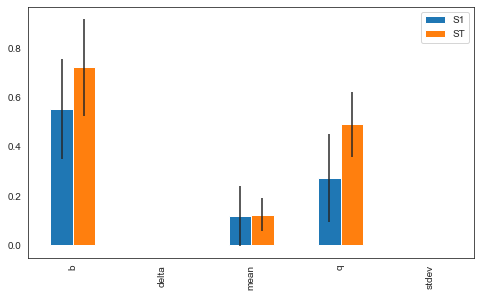

In [3]:
from SALib.analyze.sobol import analyze
problem = get_SALib_problem(model.uncertainties)

sobol_results = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    y = outcomes['reliability'][logical]
    Si = analyze(problem, y)
    sobol_results[policy] = Si
    
    print(Si)
    scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()

2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category


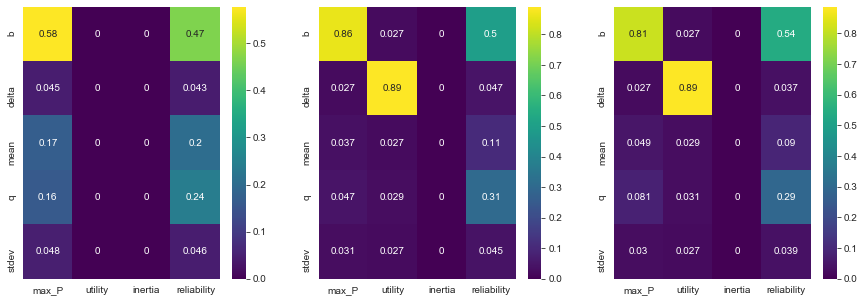

In [4]:
from ema_workbench.analysis import feature_scoring
experiments_cleaned = experiments.drop(columns=['model', 'scenario'])

f,axes=plt.subplots(1,3, figsize=(15,5))
for i, policy in enumerate(experiments_cleaned.policy.unique()):
    logical = experiments_cleaned.policy == policy
    subset_results = {k:v[logical] for k, v in outcomes.items()}
    scores = feature_scoring.get_feature_scores_all(experiments_cleaned[logical], subset_results)

    sns.heatmap(scores, ax=axes[i], annot=True, cmap='viridis')
    plt.show

**Interpretation:** b has effects on max_p and reliability.  
For no_release (1st graph), no utility because nothing is dumped \
Utility (in other two scenario's), is mainly effected by delta \
Stdev does not effect any output

Finally, the colors / size of the effects match the SOBOL analysis